In [1]:
!mkdir -p ~/work/word_embedding

# 벡터화 실습: 원-핫 인코딩 구현해보기  

## 1. 패키지  설치하기

In [3]:
!sudo apt update
!sudo apt install openjdk-17-jdk -y
!echo 'export JAVA_HOME=$(dirname $(dirname $(readlink -f $(which java))))' >> ~/.bashrc
!source ~/.bashrc

!pip install konlpy

Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble InRelease0m
Hit:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
83 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk is already the newest version (17.0.17+10-1~24.04).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


In [5]:
import re
from konlpy.tag import Okt
from collections import Counter
print("임포트 완료")

임포트 완료


In [6]:
text = "임금님 귀는 당나귀 귀! 임금님 귀는 당나귀 귀! 실컷~ 소리치고 나니 속이 확 뚫려 살 것 같았어."
text

'임금님 귀는 당나귀 귀! 임금님 귀는 당나귀 귀! 실컷~ 소리치고 나니 속이 확 뚫려 살 것 같았어.'

## 2. 전처리 이야기

In [7]:
reg = re.compile("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]")
text = reg.sub('', text)
print(text)

임금님 귀는 당나귀 귀 임금님 귀는 당나귀 귀 실컷 소리치고 나니 속이 확 뚫려 살 것 같았어


## 3. 토큰화 이야기

In [8]:
%%time
okt=Okt()
tokens = okt.morphs(text)
print(tokens)

['임금님', '귀', '는', '당나귀', '귀', '임금님', '귀', '는', '당나귀', '귀', '실컷', '소리', '치고', '나니', '속이', '확', '뚫려', '살', '것', '같았어']
CPU times: user 12.7 s, sys: 1.62 s, total: 14.3 s
Wall time: 9.62 s


## 4. 단어장 만들기 

In [14]:
vocab = Counter(tokens)
print(vocab)

print(vocab['임금님'])

vocab_size = 5
vocab = vocab.most_common(vocab_size) # 등장 빈도수가 높은 상위 5개의 단어만 저장
print(vocab)

word2idx={word[0] : index+1 for index, word in enumerate(vocab)}
print(word2idx)

Counter({'귀': 4, '임금님': 2, '는': 2, '당나귀': 2, '실컷': 1, '소리': 1, '치고': 1, '나니': 1, '속이': 1, '확': 1, '뚫려': 1, '살': 1, '것': 1, '같았어': 1})
2
[('귀', 4), ('임금님', 2), ('는', 2), ('당나귀', 2), ('실컷', 1)]
{'귀': 1, '임금님': 2, '는': 3, '당나귀': 4, '실컷': 5}


## 5. 원-핫 벡터 만들기

In [12]:
def one_hot_encoding(word, word2index):
       one_hot_vector = [0]*(len(word2index))
       index = word2index[word]
       one_hot_vector[index-1] = 1
       return one_hot_vector
print("슝=3")

슝=3


In [17]:
one_hot_encoding("임금님", word2idx)

[0, 1, 0, 0, 0]

In [18]:
import torch
import torch.nn.functional as F
from collections import Counter
print("임포트 완료")

임포트 완료


In [19]:
text = [['강아지', '고양이', '강아지'],['애교', '고양이'], ['컴퓨터', '노트북']]
text

[['강아지', '고양이', '강아지'], ['애교', '고양이'], ['컴퓨터', '노트북']]

In [20]:
text = [['강아지', '고양이', '강아지'], ['애교', '고양이'], ['컴퓨터', '노트북']] # 데이터
counter = Counter(word for sentence in text for word in sentence) # 단어 등장 빈도 계산
word_index = {word: i+1 for i, (word, _) in enumerate(counter.most_common())}
word_index["<PAD>"] = 0   # OOV(Out-of-Vocabulary) 처리를 위해 기본 인덱스 설정

print(word_index)

{'강아지': 1, '고양이': 2, '애교': 3, '컴퓨터': 4, '노트북': 5, '<PAD>': 0}


In [21]:
vocab_size = len(word_index) # 단어 사전 크기
print("슝=3")

슝=3


In [22]:
sub_text = ['강아지', '고양이', '강아지', '컴퓨터']
encoded = [word_index.get(word, 0) for word in sub_text]  # OOV 단어는 0으로 처리
print(encoded)

[1, 2, 1, 4]


In [23]:
encoded_tensor = torch.tensor(encoded, dtype=torch.long) # PyTorch 텐서 변환
one_hot = F.one_hot(encoded_tensor, num_classes=len(word_index))
print(one_hot)

tensor([[0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]])


#  워드 임베딩

- **DTM, TF-IDF, 원-핫 벡터**: 단어장의 크기에 영향을 받는 **희소 벡터(sparse vector)**  
- 희소 벡터에는 **차원의 저주(curse of dimensionality)** 라는 문제가 발생한다. 고차원에서 정보가 흩어지며 밀도가 작아진다.  
- **원-핫 벡터가 가지는 문제점**: 단어의 의미적 유사도를 판단할 수 없다.  
- **워드 임베딩**: 기계가 단어장 크기보다 적은 차원의 밀집 벡터(dense vector)를 학습하여 각 차원이 0과 1이 아닌 다양한 실수값을 가짐. 이 밀집 벡터를 임베딩 벡터라고 함  

  -> 결과물: 단어의 의미나 단어 간의 관계를 내포하고 있는 밀집 벡터  
  -> 어떻게 얻어지나? 훈련 데이터의 모델 학습과정에서 loss function(손실함수)와 gradient descent(경사하강법)을 통해 자동으로 얻어짐

## 1. Word2Vec

1.1 분포 가설(Distributional hypothesis)  
- 비슷한 문맥에서 같이 등장하는 경향이 있는 단어들은 비슷한 의미를 가진다.  
  
1.2 CBoW(Continuous Bag of Words)  
- CBoW는 주변에 있는 단어들을 통해 중간에 있는 단어들을 예측하는 방법  
- 단점: OOV에 약함, 다의어에 약함, 단어 순서 정보를 잃어 문맥 파악이 어려움  

**슬라이딩 윈도우**:  
  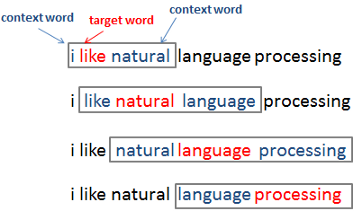  
  - 데이터셋의 형식은 ((주변 단어의 셋), 중심 단어): ((like), I), ((I, natural), like), ((like, language), natural), ((natural, processing), language), ((language), processing)  
  
1.3 Skip-gram과 Negative Sampling  
- 중간에 있는 단어로 주변 단어들을 예측하는 방법  
- 데이터셋의 형식은 (중심 단어, 주변 단어): (i, like) (like, I), (like, natural), (natural, like), (natural, language), (language, natural), (language, processing), (processing, language)  
- Negative Sampling은 연산량을 줄이기 위해서 softmax(다중클래스 분류) -> sigmoid(이진 분류)로 바꿈.  
- Negative Sampling은 주어진 데이터에서 무작위로 음성(negative) 샘플을 추출하는 방법  
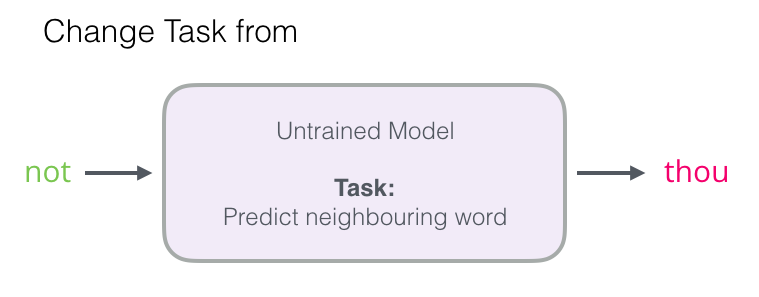 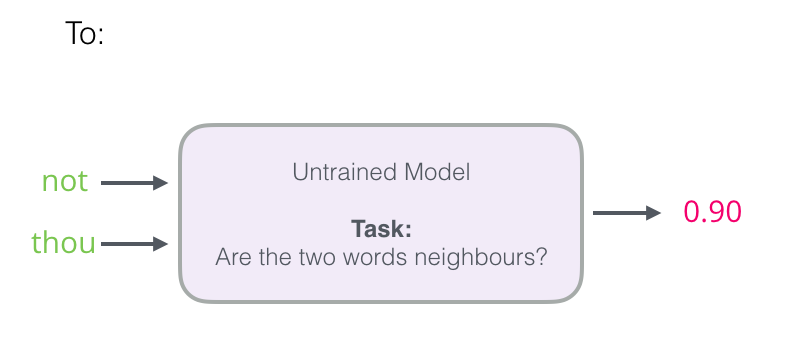

1.4 영어 Word2Vec 실습과 OOV 문제

In [42]:
#주의⚠️ 라이브러리 버전 변경 내역이 반영될 수 있도록 커널 리셋!!
!pip install nltk==3.6.7
!pip install gensim==4.3.2
!pip install scipy==1.12.0 numpy==1.26.2

  Using cached nltk-3.6.7-py3-none-any.whl.metadata (2.8 kB)
Using cached nltk-3.6.7-py3-none-any.whl (1.5 MB)
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.2
    Uninstalling nltk-3.9.2:
      Successfully uninstalled nltk-3.9.2
  Using cached scipy-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.8 MB)
Using cached numpy-1.26.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]
    Found existing installation: scipy 1.17.0 0/2 [numpy]
    Uninstalling scipy-1.17.0:0m╺━━━━━━━━━━━━━━━━━━━ 1/2 [scipy]
      Succes

In [1]:
import nltk
nltk.download('abc')
nltk.download('punkt')

[nltk_data] Downloading package abc to /home/jovyan/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from nltk.corpus import abc
corpus = abc.sents()
print("슝~")

슝~


In [3]:
print(corpus[:3])

[['PM', 'denies', 'knowledge', 'of', 'AWB', 'kickbacks', 'The', 'Prime', 'Minister', 'has', 'denied', 'he', 'knew', 'AWB', 'was', 'paying', 'kickbacks', 'to', 'Iraq', 'despite', 'writing', 'to', 'the', 'wheat', 'exporter', 'asking', 'to', 'be', 'kept', 'fully', 'informed', 'on', 'Iraq', 'wheat', 'sales', '.'], ['Letters', 'from', 'John', 'Howard', 'and', 'Deputy', 'Prime', 'Minister', 'Mark', 'Vaile', 'to', 'AWB', 'have', 'been', 'released', 'by', 'the', 'Cole', 'inquiry', 'into', 'the', 'oil', 'for', 'food', 'program', '.'], ['In', 'one', 'of', 'the', 'letters', 'Mr', 'Howard', 'asks', 'AWB', 'managing', 'director', 'Andrew', 'Lindberg', 'to', 'remain', 'in', 'close', 'contact', 'with', 'the', 'Government', 'on', 'Iraq', 'wheat', 'sales', '.']]


In [4]:
print('코퍼스의 크기 :',len(corpus))

코퍼스의 크기 : 29059


In [5]:
%%time
from gensim.models import Word2Vec

model = Word2Vec(sentences = corpus,
                 vector_size = 100, # 학습 후 임베딩 벡터의 차원
                 window = 5, # 컨텍스트 윈도우 크기
                 min_count = 5, # 단어 최소 빈도수 제한 (빈도가 적은 단어들은 학습하지 않아요.)
                 workers = 4, # 학습을 위한 프로세스 수
                 sg = 0) #0은 CBoW, 1은 Skip-gram.
print("모델 학습 완료!")

모델 학습 완료!
CPU times: user 26.3 s, sys: 978 ms, total: 27.3 s
Wall time: 26.1 s


In [6]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.9233628511428833), ('skull', 0.911035418510437), ('Bang', 0.9056946039199829), ('asteroid', 0.9051967263221741), ('third', 0.9019070267677307), ('baby', 0.8993684649467468), ('dog', 0.8985048532485962), ('bought', 0.8974266052246094), ('rally', 0.8912966847419739), ('dinosaur', 0.8889055252075195)]


In [7]:
from gensim.models import KeyedVectors

model.wv.save_word2vec_format('~/work/word_embedding/w2v')
loaded_model = KeyedVectors.load_word2vec_format("~/work/word_embedding/w2v")
print("모델  load 완료!")

모델  load 완료!


In [8]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.9233628511428833), ('skull', 0.911035418510437), ('Bang', 0.9056946039199829), ('asteroid', 0.9051967263221741), ('third', 0.9019070267677307), ('baby', 0.8993684649467468), ('dog', 0.8985048532485962), ('bought', 0.8974266052246094), ('rally', 0.8912966847419739), ('dinosaur', 0.8889055252075195)]


In [9]:
# 에러가 나더라도 놀라지 마세요. "overacting"은 훈련 데이터에 없는 단어,
# 다시 말해 단어장에 존재하지 않는 단어므로 이 코드는 에러를 발생시킵니다.
# 에러 문구를 해석해보면 "단어 'overacting'은 단어장에 없습니다." 라는 의미죠.
# 없는 단어에 대해서 임베딩 벡터값을 얻을 수는 없으니까요.
loaded_model.most_similar('overacting')
#loaded_model.most_similar('memorry')

KeyError: "Key 'overacting' not present in vocabulary"

## 2. 임베딩 벡터의 시각화

In [10]:
!python -m gensim.scripts.word2vec2tensor --input ~/work/word_embedding/w2v --output ~/work/word_embedding/w2v

2026-01-28 06:42:13,829 - word2vec2tensor - INFO - running /opt/conda/lib/python3.12/site-packages/gensim/scripts/word2vec2tensor.py --input /home/jovyan/work/word_embedding/w2v --output /home/jovyan/work/word_embedding/w2v
2026-01-28 06:42:13,830 - keyedvectors - INFO - loading projection weights from /home/jovyan/work/word_embedding/w2v
2026-01-28 06:42:14,721 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (10363, 100) matrix of type float32 from /home/jovyan/work/word_embedding/w2v', 'binary': False, 'encoding': 'utf8', 'datetime': '2026-01-28T06:42:14.716621', 'gensim': '4.3.2', 'python': '3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:45:31) [GCC 13.3.0]', 'platform': 'Linux-6.6.113+-x86_64-with-glibc2.39', 'event': 'load_word2vec_format'}
2026-01-28 06:42:15,732 - word2vec2tensor - INFO - 2D tensor file saved to /home/jovyan/work/word_embedding/w2v_tensor.tsv
2026-01-28 06:42:15,732 - word2vec2tensor - INFO - Tensor metadata file saved to /home/jovyan/w

In [11]:
!ls ~/work/word_embedding/

w2v  w2v_metadata.tsv  w2v_tensor.tsv


링크: [Embedding Projector](https://projector.tensorflow.org/)

## 3. FastText  

- 메커니즘 자체는 Word2Vec을 그대로 따르고 있지만, 문자 단위 n-gram(character-level n-gram) 표현을 학습함  
- Word2Vec은 단어를 더 이상 깨질 수 없는 단위로 구분하는 반면, FastText는 단어 내부의 내부 단어(subwords)들을 학습한다는 아이디어를 가지고 있음  

In [14]:
%%time
from gensim.models import FastText
fasttext_model = FastText(corpus, window=5, min_count=5, workers=4, sg=1)
print("FastText 학습 완료!")

FastText 학습 완료!
CPU times: user 1min 27s, sys: 2.52 s, total: 1min 30s
Wall time: 54.6 s


In [15]:
fasttext_model.wv.most_similar('overacting')

[('extracting', 0.9409341812133789),
 ('resolving', 0.9350695013999939),
 ('mounting', 0.9315288662910461),
 ('shooting', 0.9309358596801758),
 ('emptying', 0.9306812882423401),
 ('negotiating', 0.9288661479949951),
 ('attracting', 0.9268788695335388),
 ('lifting', 0.9247300028800964),
 ('contracting', 0.9242857694625854),
 ('malting', 0.9240557551383972)]

In [16]:
fasttext_model.wv.most_similar('memoryy')

[('memory', 0.947685182094574),
 ('musical', 0.876162052154541),
 ('emotion', 0.8576261401176453),
 ('mechanism', 0.8533077836036682),
 ('mechanical', 0.8511000275611877),
 ('essence', 0.849616527557373),
 ('mechanisms', 0.8474490642547607),
 ('violence', 0.8467687964439392),
 ('basic', 0.8408838510513306),
 ('imagine', 0.838563084602356)]

In [17]:
#한국어에서 FastText가 빛을 발하는 것은 사실 음절 단위라기보다는 자소 단위
#자소 단위 FastText: <ㅌㅔ,ㅌㅔㄴ,ㅔㄴㅅ,ㄴㅅㅓ,ㅅㅓ_, ...중략... >

## 4. GloVe  

- 카운트 기반과 예측 기반 두 가지 방법을 모두 사용함  
- 잠재 의미 분석(LSA, Latent Semantic Analysis)  
    (1) 차원 축소의 특성으로 인해 새로운 단어가 추가되면 다시 DTM을 만들어 새로 차원 축소를 해야 한다.  
    (2) 단어 벡터간 유사도를 계산하는 측면에서 Word2Vec보다 성능이 떨어진다.  
- 윈도우 기반 동시 등장 행렬(Window based Co-occurrence Matrix)  
-> 전체 코퍼스에서의 동시 등장 빈도의 로그값과 중심 단어 벡터와 주변 단어 벡터의 내적값의 차이가 최소화되도록 두 벡터의 값을 학습하는 것

In [22]:
# import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-50")  # glove vectors 다운로드
glove_model.most_similar("dog")  # 'dog'과 비슷한 단어 찾기Pre-trained GloVe 모델 실습

[('cat', 0.9218004941940308),
 ('dogs', 0.8513158559799194),
 ('horse', 0.7907583713531494),
 ('puppy', 0.7754920721054077),
 ('pet', 0.7724708318710327),
 ('rabbit', 0.7720814347267151),
 ('pig', 0.7490062117576599),
 ('snake', 0.7399188876152039),
 ('baby', 0.7395570278167725),
 ('bite', 0.7387937307357788)]

In [23]:
glove_model.most_similar('overacting')

[('impudence', 0.7842012047767639),
 ('puerile', 0.7816032767295837),
 ('winningly', 0.7644237875938416),
 ('grossness', 0.7576098442077637),
 ('deconstructions', 0.748936653137207),
 ('over-the-top', 0.7460805773735046),
 ('buffoonery', 0.746045708656311),
 ('impetuosity', 0.7415392398834229),
 ('sophomoric', 0.736961841583252),
 ('zaniness', 0.7353197336196899)]

In [24]:
# 에러가 나더라도 놀라지 마세요.
glove_model.most_similar('memoryy')

KeyError: "Key 'memoryy' not present in vocabulary"

In [19]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-50")  # glove vectors 다운로드
glove_model.most_similar("dog")  # 'dog'과 비슷한 단어 찾기

[('cat', 0.9218004941940308),
 ('dogs', 0.8513158559799194),
 ('horse', 0.7907583713531494),
 ('puppy', 0.7754920721054077),
 ('pet', 0.7724708318710327),
 ('rabbit', 0.7720814347267151),
 ('pig', 0.7490062117576599),
 ('snake', 0.7399188876152039),
 ('baby', 0.7395570278167725),
 ('bite', 0.7387937307357788)]

In [20]:
glove_model.most_similar('overacting')

[('impudence', 0.7842012047767639),
 ('puerile', 0.7816032767295837),
 ('winningly', 0.7644237875938416),
 ('grossness', 0.7576098442077637),
 ('deconstructions', 0.748936653137207),
 ('over-the-top', 0.7460805773735046),
 ('buffoonery', 0.746045708656311),
 ('impetuosity', 0.7415392398834229),
 ('sophomoric', 0.736961841583252),
 ('zaniness', 0.7353197336196899)]

In [21]:
# 에러가 나더라도 놀라지 마세요.
glove_model.most_similar('memoryy')

KeyError: "Key 'memoryy' not present in vocabulary"

# 임베딩 내 편향성 알아보기

- WEAT(Word Embedding Association Test)
    : 워드 임베딩에 숨어 있는 편향성을 측정하는 대표적인 방법론  
    - target과 attribute는 각각 두 개의 단어 셋(set)  
    - target : 비교의 대상  
    - attribute : target이 어떤 성질과 더 연결되는지 판단하는 기준  

- WEAT score  
    - cos(θ)=1: 두 벡터의 방향이 똑같을 때
    - cos(θ)=0: 두 벡터가 직교할 때
    - cos(θ)=−1: 두 벡터의 방향이 반대일 때

## 1. WEAT 구현하기

In [15]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

print("슝~")

슝~


In [6]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

print("슝~")

슝~


In [7]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [8]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [9]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

#print(s(target_X['장미'], A, B))

In [10]:
print(s(target_Y['거미'], A, B))

-0.794002342033094


In [11]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


In [12]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


In [8]:
def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return  (mean_X-mean_Y)/std_dev

#print(round(weat_score(X, Y, A, B), 3))

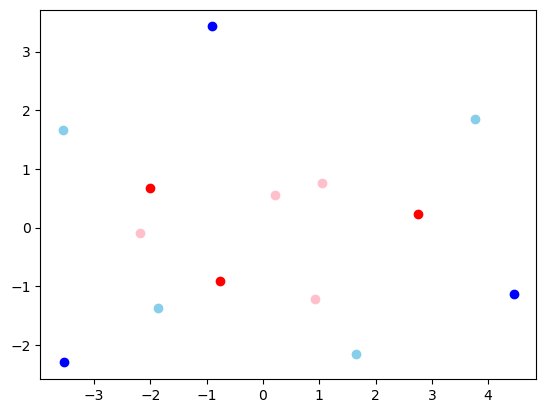

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

## 2. 사전학습된 Word Embedding에 WEAT 적용하기

In [12]:
!mkdir -p ~/work/weat/data
!ln -s ~/data/* ~/work/weat/data/

ln: failed to create symbolic link '/home/jovyan/work/weat/data/GoogleNews-vectors-negative300.bin': File exists
ln: failed to create symbolic link '/home/jovyan/work/weat/data/GoogleNews-vectors-negative300.bin.gz': File exists
ln: failed to create symbolic link '/home/jovyan/work/weat/data/synopsis.zip': File exists


In [1]:
!pip install gensim==4.3.2

# 의존성 연결을 위해 다운그레이드를 진행합니다. #커널 다시시작
!pip install scipy==1.12.0 numpy==1.26.2

In [3]:
import os
from gensim.models import KeyedVectors
import numpy as np

data_dir = os.path.join(os.getenv("HOME"), 'work/weat/data')
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다.
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [4]:
w2v

In [5]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다.
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다.
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다.
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [6]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [25]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [26]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [27]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

In [18]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

In [19]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

In [20]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

In [21]:
target_X = ['pizza', 'coke', 'hamburger', 'fries', 'steak', 'bacon', 'sausage']
target_Y = ['carrot', 'broccoli', 'spinach', 'lettuce', 'cucumber', 'avocado', 'peas']
attribute_A = ['delicious', 'tasty', 'yummy', 'flavorful', 'savory', 'appetizing']
attribute_B = ['healthy', 'nutritious', 'wholesome', 'organic', 'balanced', 'nourishing']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.3638902

In [22]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


## 3. 직접 만드는 Word Embedding에 WEAT 적용하기

In [25]:
#현재 라이브버리 버전 확인하기
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.3.2
1.7.0
0.13.2


### 3.1 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [ ]:
!cd ~/data && unzip synopsis.zip -d ~/work/weat/data/


Archive:  synopsis.zip
replace /home/jovyan/work/weat/data/synopsis.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [34]:
import os

data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")
file_name = os.path.join(data_dir, "synopsis.txt")

with open(file_name, 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [24]:
!sudo apt update
!sudo apt install openjdk-17-jdk -y
!echo 'export JAVA_HOME=$(dirname $(dirname $(readlink -f $(which java))))' >> ~/.bashrc
!source ~/.bashrc

!pip install konlpy

Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble InRelease0m
Hit:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
83 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk is already the newest version (17.0.17+10-1~24.04).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


In [35]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt

okt = Okt()
tokenized = []

with open(file_name, 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다.
        tokenized.append(res)

print("슝~")

슝~


In [5]:
print(len(tokenized))

71156


### 3.2 추출된 결과로 embedding model 만들기

In [36]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다.
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)
# model.most_similar(positive=['영화'])

[('작품', 0.8799657225608826),
 ('다큐멘터리', 0.8431684374809265),
 ('드라마', 0.8004476428031921),
 ('영화로', 0.7886818051338196),
 ('코미디', 0.7762323021888733),
 ('주제', 0.7727664709091187),
 ('형식', 0.7707546353340149),
 ('가족영화', 0.7681049108505249),
 ('감동', 0.7623870372772217),
 ('소재', 0.7594821453094482)]

In [9]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7062891721725464),
 ('애정', 0.6951822638511658),
 ('첫사랑', 0.6945903897285461),
 ('이별', 0.6911146640777588),
 ('진심', 0.6898390650749207),
 ('아르튬', 0.6846815347671509),
 ('만남', 0.6831110715866089),
 ('연애', 0.6827237010002136),
 ('고백', 0.6800382137298584),
 ('감정', 0.6739861369132996)]

In [10]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.8827103972434998),
 ('영화감독', 0.8751844167709351),
 ('연기', 0.8740739822387695),
 ('영감', 0.8630791306495667),
 ('배우', 0.862761914730072),
 ('캐스팅', 0.8593969941139221),
 ('차이밍량', 0.8559907078742981),
 ('시대극', 0.8545636534690857),
 ('뮤지션', 0.852520227432251),
 ('팬', 0.8520737290382385)]

### 3.3 TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기 / target, attribute 단어 셋 만들기  

In [28]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(data_dir + '/' + file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0]))
    return ' '.join(result)

print("슝~")

슝~


In [12]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다.
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [14]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names_out()[23976])

23976
영화


In [74]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다.
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다.

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')

print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 사실, 비밀, 기억, 전쟁, 사건, 시간, 공격, 영화, 한편, 실험, 능력, 시스템, 위협, 생명체, 정부, 아들, 사고, 스타크, 리플리, 과학자, 음모, 파괴, 아버지, 켈빈, 컨트, 모두, 수퍼맨, 임무, 가족, 발생, 요원, 죽음, 다시, 과거, 위기, 외계인, 도시, 운명, 상황, 갑자기, 이제, 분파, 연구, 불명, 때문, 개발, 탈출, 명의, 의문, 아이, 남자, 현실, 바이러스, 진화, 물체, 상어, 통해, 최후, 목숨, 프로젝트, 수트, 생존, 사랑, 과연, 히노키, 섹터, 여행, 미국, 대원, 멸망, 조직, 위험, 바로, 사이, 세력, 감염, 괴물, 거대, 

일반영화를 대표하는 단어들:
엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 국제, 마을, 낙타, 할머니, 씨제이, 동구, 사람, 아이, 사랑, 학교, 세상, 소년, 슈이트, 이야기, 가장, 어머니, 마갈, 소녀, 미아, 대한, 펠리칸, 모두, 혼자, 서울, 벤트, 케이시, 사건, 마음, 엠마, 할아버지, 크리스마스, 고양이, 사이, 아내, 최호, 요정, 모험, 혜지, 유나, 테리, 위기, 다시, 번개, 손녀, 그레고리, 결심, 과연, 시골, 파코, 영화, 작품, 해나, 스튜어트, 인형, 단편, 기억, 한편, 하나, 서로, 발견, 부산, 장난감, 아스, 도시, 누키, 크누드, 제노, 아기, 때문, 이자, 펠릭스, 노동자, 회사, 사실, 생각, 마르, 주니, 강아지, 시간, 소식, 다른, 간다, 규완, 제페토, 잉그릿, 신차, 우산, 모든, 

In [75]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [76]:
print(target_art)

['지구', '인류', '인간', '미래', '우주', '로봇', '세계', '박사', '우주선', '외계', '존재', '행성', '정체', '비밀', '전쟁']


In [77]:
print(target_gen)

['엄마', '아빠', '영화제', '아주르', '국제', '마을', '낙타', '할머니', '씨제이', '동구', '학교', '소년', '슈이트', '이야기', '가장']


In [26]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


In [29]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [30]:
# TF-IDF 기반 단어 셋 생성
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [57]:
m = [X[i].tocoo() for i in range(X.shape[0])] #희소 벡터 → (단어 인덱스, tf-idf 값)으로 변환

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m] # 각 문서별로 [단어 인덱스, tf-idf 값] 리스트 생성

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True) # 문서별 TF-IDF 상위 단어 정렬
    
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    
    while (len(attr) < 15):
        word = vectorizer.get_feature_names_out()[w[i][j][0]]
        
        if word in model.wv:
            attr.append(word)
            print(word, end=', ')
        j += 1
       
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 국제, 마을, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 프롤, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 아이, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 사람, 운명, 최고, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 태구, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시

In [59]:
#전체 장르 중 N% 이상에서 등장하면 제거

from collections import Counter
import math

# 1. 각 장르에서 중복 제거한 단어들 모으기
all_words = []
for attr in attributes:
    all_words.extend(set(attr))

# 2. 장르별 등장 빈도 계산
word_counter = Counter(all_words)

num_genres = len(attributes)
threshold = math.ceil(num_genres * 0.5)  # 50% 이상 등장 시 공통어

common_words = {
    word for word, cnt in word_counter.items()
    if cnt >= threshold
}

print("제거될 공통 단어:", common_words)


제거될 공통 단어: {'위해', '그녀', '자신', '사람', '시작'}


In [62]:
filtered_attributes = []

for attr in attributes:
    filtered = [w for w in attr if w not in common_words]
    filtered_attributes.append(filtered)

print(filtered_attributes)

[['지구', '인류', '인간', '미래', '우주', '로봇', '세계', '모든', '박사', '우주선'], ['엄마', '아빠', '가족', '영화제', '친구', '아주르', '아버지', '아들', '국제', '마을', '낙타'], ['오페라', '사랑', '토스카', '실황', '올레', '카바', '공연', '오텔로', '리골레토', '백작', '프레', '베르디'], ['친구', '사건', '공포', '발견', '죽음', '마을', '가족', '악령', '남자', '좀비'], ['영화제', '국제', '서울', '단편', '영화', '이야기', '남자', '사랑', '뉴미디어', '페스티벌'], ['영화제', '영화', '다큐', '국제', '다큐멘터리', '이야기', '대한', '감독', '서울', '우리', '세계'], ['영화제', '사랑', '영화', '국제', '남자', '친구', '이야기', '엄마', '여자', '아버지'], ['사랑', '남편', '남자', '여자', '친구', '섹스', '마음', '결혼', '서로', '아내'], ['뮤지컬', '사랑', '에스메랄다', '음악', '충무로', '모차르트', '영화', '토스카', '니웨', '카바', '영화제', '바흐', '프롤'], ['사건', '발견', '사고', '진실', '죽음', '기억', '살인', '친구', '아내', '아이'], ['사건', '경찰', '범죄', '조직', '살인', '마약', '형사', '남자', '모든', '살해'], ['조선', '신기전', '사랑', '아가멤논', '황제', '루안', '운명', '최고', '하선', '전쟁'], ['서부', '보안관', '벌린', '카우보이', '그레이프바인', '헨리', '마을', '개릿', '아이', '무법자', '프린트', '태구'], ['남편', '마사지', '섹스', '관계', '영화', '정사', '남자', '여자', '유부녀', '마음', '사랑'], ['사건', '살인', '남자', '발견',

In [67]:
#단어 갯수 확인
for name, attr in zip(genre_name, filtered_attributes):
    print(name, len(attr))

SF 10
가족 11
공연 12
공포(호러) 10
기타 10
다큐멘터리 11
드라마 10
멜로로맨스 10
뮤지컬 13
미스터리 10
범죄 10
사극 10
서부극(웨스턴) 12
성인물(에로) 11
스릴러 10
애니메이션 11
액션 10
어드벤처 11
전쟁 11
코미디 10
판타지 10


In [68]:
# TF-IDF 상위 15개 > 중복 50% 이상 단어 제거 > 결과:각 장르당 10~12개 단어 > 전부 10개로 맞춤
final_attributes = [words[:10] for words in filtered_attributes]
final_attributes

[['지구', '인류', '인간', '미래', '우주', '로봇', '세계', '모든', '박사', '우주선'],
 ['엄마', '아빠', '가족', '영화제', '친구', '아주르', '아버지', '아들', '국제', '마을'],
 ['오페라', '사랑', '토스카', '실황', '올레', '카바', '공연', '오텔로', '리골레토', '백작'],
 ['친구', '사건', '공포', '발견', '죽음', '마을', '가족', '악령', '남자', '좀비'],
 ['영화제', '국제', '서울', '단편', '영화', '이야기', '남자', '사랑', '뉴미디어', '페스티벌'],
 ['영화제', '영화', '다큐', '국제', '다큐멘터리', '이야기', '대한', '감독', '서울', '우리'],
 ['영화제', '사랑', '영화', '국제', '남자', '친구', '이야기', '엄마', '여자', '아버지'],
 ['사랑', '남편', '남자', '여자', '친구', '섹스', '마음', '결혼', '서로', '아내'],
 ['뮤지컬', '사랑', '에스메랄다', '음악', '충무로', '모차르트', '영화', '토스카', '니웨', '카바'],
 ['사건', '발견', '사고', '진실', '죽음', '기억', '살인', '친구', '아내', '아이'],
 ['사건', '경찰', '범죄', '조직', '살인', '마약', '형사', '남자', '모든', '살해'],
 ['조선', '신기전', '사랑', '아가멤논', '황제', '루안', '운명', '최고', '하선', '전쟁'],
 ['서부', '보안관', '벌린', '카우보이', '그레이프바인', '헨리', '마을', '개릿', '아이', '무법자'],
 ['남편', '마사지', '섹스', '관계', '영화', '정사', '남자', '여자', '유부녀', '마음'],
 ['사건', '살인', '남자', '발견', '아내', '경찰', '친구', '모든', '사실', '살해'],
 ['애니메이션', 

In [69]:
for name, attr in zip(genre_name, final_attributes):
    print(name, len(attr))

SF 10
가족 10
공연 10
공포(호러) 10
기타 10
다큐멘터리 10
드라마 10
멜로로맨스 10
뮤지컬 10
미스터리 10
범죄 10
사극 10
서부극(웨스턴) 10
성인물(에로) 10
스릴러 10
애니메이션 10
액션 10
어드벤처 10
전쟁 10
코미디 10
판타지 10


### 3.4 embedding model과 단어 셋으로 WEAT score 구해보기

- 개념축(target): 예술영화 vs 일반영화  
- 영화 장르별 대표 단어(attribute)를 기준으로 각 장르가 어느쪽 새념에 가깝게 편향되어 있는 지 정량화  

In [78]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [79]:
X = np.array([model.wv[word] for word in target_art]) # traget_X는 art
Y = np.array([model.wv[word] for word in target_gen]) # target_Y는 gen

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]]) # attribute_A와 attribute_B는 바꿔가면서 구현함
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [105]:
#전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 1.6328584
SF 공연 1.6102735
SF 공포(호러) 1.2210919
SF 기타 1.612102
SF 다큐멘터리 1.5452895
SF 드라마 1.7070005
SF 멜로로맨스 1.4781605
SF 뮤지컬 1.5851754
SF 미스터리 1.1669546
SF 범죄 0.9969246
SF 사극 1.560356
SF 서부극(웨스턴) 1.5635613
SF 성인물(에로) 1.5343248
SF 스릴러 1.174297
SF 애니메이션 1.6914192
SF 액션 1.0642349
SF 어드벤처 1.5893801
SF 전쟁 0.5812282
SF 코미디 1.6463746
SF 판타지 1.6933494
가족 공연 -0.93126047
가족 공포(호러) -1.2868934
가족 기타 -0.27100593
가족 다큐멘터리 -0.57371014
가족 드라마 -0.3235601
가족 멜로로맨스 -0.1999664
가족 뮤지컬 -0.3496794
가족 미스터리 -1.1148666
가족 범죄 -1.3973771
가족 사극 -1.4745613
가족 서부극(웨스턴) -1.2716814
가족 성인물(에로) -0.0078123007
가족 스릴러 -1.1221133
가족 애니메이션 -0.25590882
가족 액션 -1.5460374
가족 어드벤처 -1.1071584
가족 전쟁 -1.509174
가족 코미디 -0.93467677
가족 판타지 -1.12929
공연 공포(호러) -0.53291976
공연 기타 0.5558121
공연 다큐멘터리 -0.054675937
공연 드라마 1.0560474
공연 멜로로맨스 0.6104958
공연 뮤지컬 0.4807587
공연 미스터리 -0.33167416
공연 범죄 -0.9990113
공연 사극 -1.3506876
공연 서부극(웨스턴) -0.13926019
공연 성인물(에로) 0.9074751
공연 스릴러 -0.36742735
공연 애니메이션 0.6886893
공연 액션 -1.0522615
공연 어드벤처 -0.18293095
공연

In [98]:
!ls ~/work/fonts


NanumGothic.ttf      NanumGothicExtraBold.ttf
NanumGothicBold.ttf  NanumGothicLight.ttf


In [99]:
#!apt-get update -qq
#!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm

# 폰트 경로
font_path = os.path.expanduser('~/work/fonts/NanumGothic.ttf')

# 폰트 등록
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

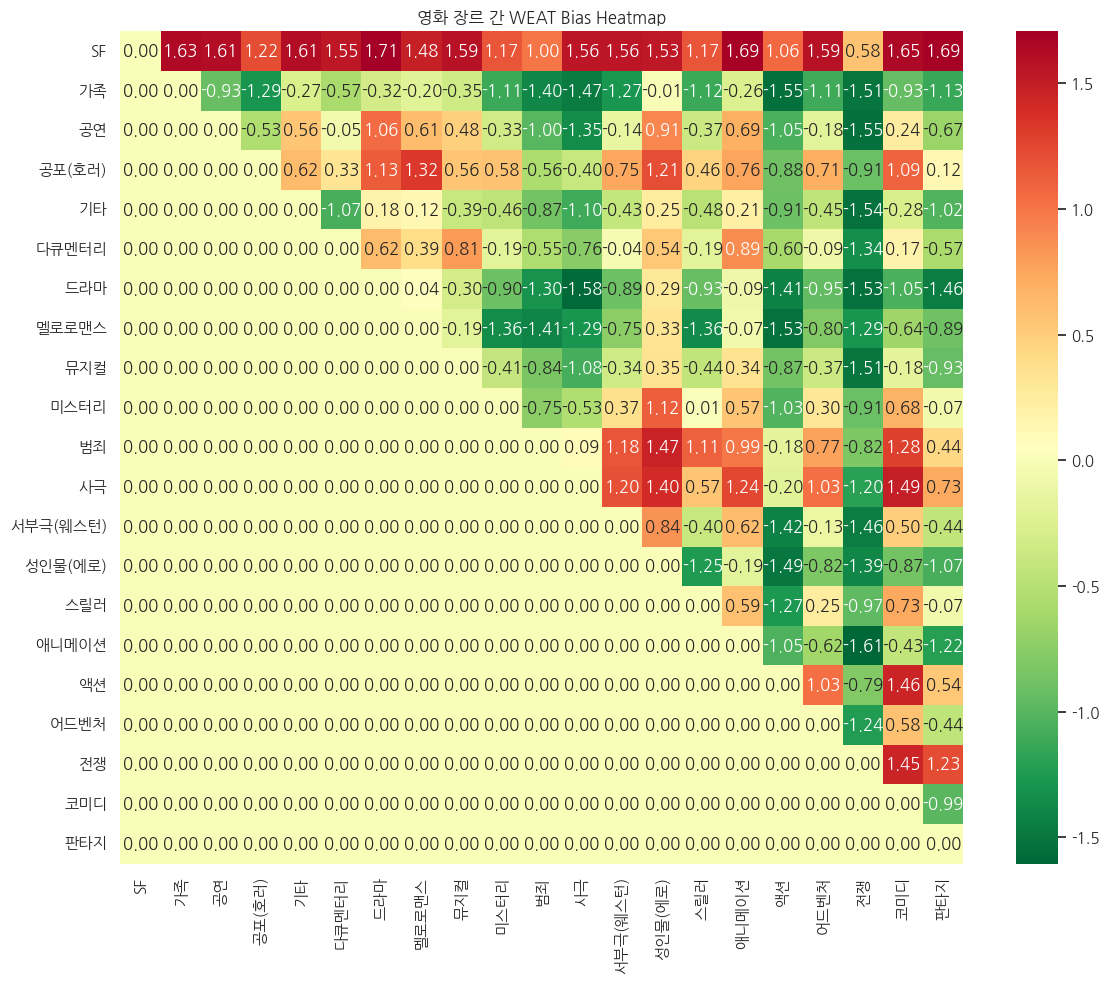

In [108]:
#시각화

# matplotlib 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# seaborn 설정
sns.set(font=font_name)

# Heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    matrix,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    cmap='RdYlGn_r',
    fmt=".2f"
)
plt.title("영화 장르 간 WEAT Bias Heatmap")
plt.tight_layout()
plt.show()

In [124]:
threshold = 0.8 
biased_weat = []

# WEAT score가 임계값 이상인 쌍만 저장
for i in range(len(genre_name)):
    for j in range(len(genre_name)):
        score = weat_df.iloc[i, j]
        if score >= threshold or score <= -threshold:
            biased_weat.append((genre_name[i], genre_name[j], score))

# 절대값 기준 내림차순 정렬
biased_weat_sorted = sorted(
    biased_weat,
    key=lambda x: abs(x[2]),
    reverse=True
)

# 출력
for g1, g2, score in biased_weat_sorted:
    if score > 0:
        closer = g1  # 양수 → 왼쪽 장르가 예술영화에 가까움
    else:
        closer = g2  # 음수 → 오른쪽 장르가 예술영화에 가까움
    print(f"{g1} - {g2} : {score:.2f} → 예술영화에 더 가까운 장르: {closer}")

SF - 드라마 : 1.71 → 예술영화에 더 가까운 장르: SF
SF - 애니메이션 : 1.69 → 예술영화에 더 가까운 장르: SF
SF - 판타지 : 1.69 → 예술영화에 더 가까운 장르: SF
SF - 코미디 : 1.65 → 예술영화에 더 가까운 장르: SF
SF - 가족 : 1.63 → 예술영화에 더 가까운 장르: SF
SF - 공연 : 1.61 → 예술영화에 더 가까운 장르: SF
SF - 기타 : 1.61 → 예술영화에 더 가까운 장르: SF
애니메이션 - 전쟁 : -1.61 → 예술영화에 더 가까운 장르: 전쟁
SF - 뮤지컬 : 1.59 → 예술영화에 더 가까운 장르: SF
SF - 어드벤처 : 1.59 → 예술영화에 더 가까운 장르: SF
드라마 - 사극 : -1.58 → 예술영화에 더 가까운 장르: 사극
SF - 사극 : 1.56 → 예술영화에 더 가까운 장르: SF
SF - 서부극(웨스턴) : 1.56 → 예술영화에 더 가까운 장르: SF
SF - 다큐멘터리 : 1.55 → 예술영화에 더 가까운 장르: SF
가족 - 액션 : -1.55 → 예술영화에 더 가까운 장르: 액션
공연 - 전쟁 : -1.55 → 예술영화에 더 가까운 장르: 전쟁
기타 - 전쟁 : -1.54 → 예술영화에 더 가까운 장르: 전쟁
SF - 성인물(에로) : 1.53 → 예술영화에 더 가까운 장르: SF
드라마 - 전쟁 : -1.53 → 예술영화에 더 가까운 장르: 전쟁
멜로로맨스 - 액션 : -1.53 → 예술영화에 더 가까운 장르: 액션
가족 - 전쟁 : -1.51 → 예술영화에 더 가까운 장르: 전쟁
뮤지컬 - 전쟁 : -1.51 → 예술영화에 더 가까운 장르: 전쟁
사극 - 코미디 : 1.49 → 예술영화에 더 가까운 장르: 사극
성인물(에로) - 액션 : -1.49 → 예술영화에 더 가까운 장르: 액션
SF - 멜로로맨스 : 1.48 → 예술영화에 더 가까운 장르: SF
가족 - 사극 : -1.47 → 예술영화에 더 가까운 장르: 사극
범죄 - 성인물(에로)

In [127]:
from collections import Counter

# 예술영화/일반영화에 가까운 장르 추출
art_closer = []
general_closer = []

for g1, g2, score in biased_weat_sorted:
    if score > 0:
        art_closer.append(g1)      # 양수 → 왼쪽 장르가 예술영화에 가까움
        general_closer.append(g2)  # 오른쪽 장르는 상대적으로 일반영화에 가까움
    else:
        art_closer.append(g2)      # 음수 → 오른쪽 장르가 예술영화에 가까움
        general_closer.append(g1)  # 왼쪽 장르는 일반영화에 가까움

# 등장 횟수 세기
art_counter = Counter(art_closer)
general_counter = Counter(general_closer)

# 등장 횟수 기준 내림차순 정렬
sorted_art = art_counter.most_common()
sorted_general = general_counter.most_common()

# 출력
print("=== 예술영화에 더 가까운 장르 등장 횟수 ===")
for genre, count in sorted_art:
    print(f"{genre}: {count}회")

print("\n=== 일반영화에 더 가까운 장르 등장 횟수 ===")
for genre, count in sorted_general:
    print(f"{genre}: {count}회")


=== 예술영화에 더 가까운 장르 등장 횟수 ===
SF: 19회
전쟁: 18회
액션: 14회
사극: 11회
범죄: 11회
판타지: 8회
공포(호러): 5회
미스터리: 4회
스릴러: 4회
어드벤처: 4회
서부극(웨스턴): 3회
다큐멘터리: 3회
공연: 3회
코미디: 3회

=== 일반영화에 더 가까운 장르 등장 횟수 ===
드라마: 13회
가족: 13회
성인물(에로): 13회
멜로로맨스: 10회
애니메이션: 7회
코미디: 7회
기타: 7회
뮤지컬: 7회
공연: 5회
서부극(웨스턴): 5회
어드벤처: 4회
스릴러: 4회
공포(호러): 3회
미스터리: 3회
판타지: 2회
사극: 2회
다큐멘터리: 2회
범죄: 2회
액션: 1회


### 결과

**결과**  
- 장르1 - 장르2 : Score
  
**해석**  
- 양수(+): 장르1이 예술영화쪽에 더 가깝다.  
- 음수(-): 장르2가 예술영화쪽에 더 가깝다.  

즉,  
- **SF**가 드라마, 애니메이션, 판타지, 코미디, 가족, 공연, 사극, 서부극(웨스턴), 다큐멘터리, 성인물(에로), 기타 보다 **예술영화**에 가깝게 위치하는 경향을 보였다. SF 장르는 거의 모든 장르 대비 예술영화와 강하게 연관됨을 볼 수 있다.  
- **전쟁영화**는 애니메이션, 공연, 드라마, 가족, 뮤지컬 영화에 비해 **예술영화**에 더 가깝다.  
- 가족, 멜로로맨스보다는 **액션**이 **예술영화**쪽에 가깝다.  
- 드라마보다는 **사극**이 **예술영화**쪽에 더 가깝다.
- 예술영화 및 일반영화에 더 가까운 장르 등장 횟수를 확인해보면 **SF, 전쟁, 액션**은 다른 영화들에 비해 **예술영화**에 가깝고, **드라마, 가족, 성인물(에로)** 은 **일반영화**에 더 가깝다고 볼 수 있다.

**회고**  
- HEATMAP 이외에 좀더 직관적인 시각화 방법이 있으면 좋을 것 같다.  